In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [10]:
#median = 5
#std_deviation = 2.5
Ndata = 1000

data = np.concatenate([np.ones(Ndata//2),-np.ones(Ndata//2)])

<BarContainer object of 20 artists>

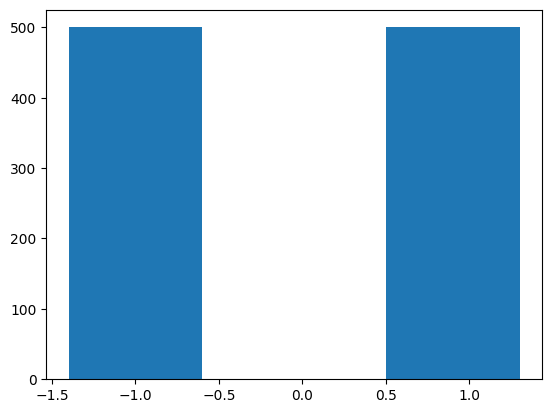

In [11]:
hist, bins_ = np.histogram(data,bins=20)
fig, ax = plt.subplots()

ax.bar(bins_[:-1], hist)

In [31]:
def linear_beta_schedule(steps, start=0.0001, end=0.02):
    return np.linspace(start, end, steps)

def alpha_normaliced(step):
    return np.prod(linear_beta_schedule(step))

def forward_process(data, steps):
    alpha_ = alpha_normaliced(steps)
    noise = np.random.normal(loc=0, scale=1, size=len(data))
    return alpha_ * data + np.sqrt(1 - alpha_)*noise

In [38]:
noised_data = forward_process(data,10)

<BarContainer object of 200 artists>

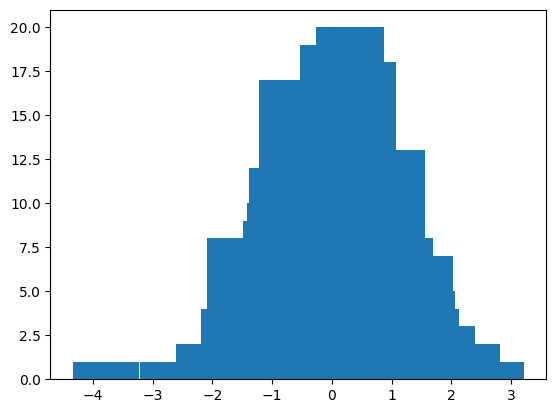

In [39]:
hist, bins_ = np.histogram(noised_data,bins=200)
fig, ax = plt.subplots()

ax.bar(bins_[:-1], hist)